In [1]:
from utils import generate_diff_report

df = generate_diff_report(
    orig_path="/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/utils/mitigation/LandManager_findings.json",
    v1_path="/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/logs/mitigation/adjustments/audit_agent_mitigation.json",
    cot_path="/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/logs/mitigation/adjustments/cot_schema2_o4-mini_2025-04-25_14-10-05_adjustments.json",
    output_csv="diff_report_o4_fullmd.csv"
)

In [2]:
import pandas as pd

df_dynamic = pd.read_csv("diff_report_dynamic.csv")
df_html = pd.read_csv("diff_report_html.csv")
df_demo = pd.read_csv("diff_report_demo.csv")
df_o4 = pd.read_csv("diff_report_o4_html.csv")
df_o4_md = pd.read_csv("diff_report_o4_fullmd.csv")
df_o4_md.head()

,index,orig_severity,v1_severity,v1_false_positive,v1_severity_delta,cot_severity,cot_false_positive,cot_severity_delta
0,0,high,low,True,less_severe,medium,False,less_severe
1,1,medium,medium,False,unchanged,medium,False,unchanged
2,2,low,low,False,unchanged,medium,False,more_severe
3,3,low,low,False,unchanged,low,False,unchanged
4,4,low,medium,False,more_severe,medium,False,more_severe


# CoT

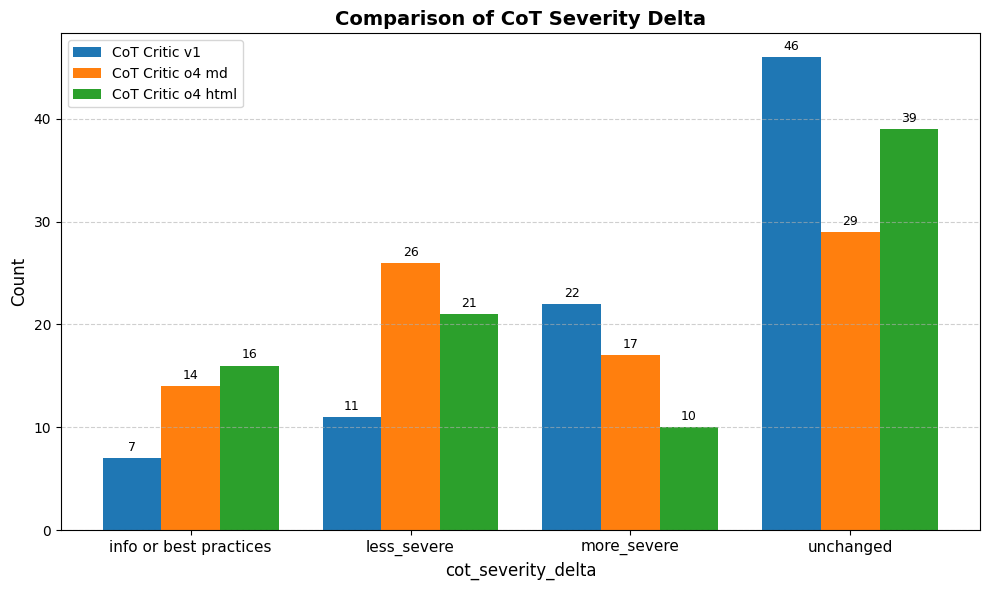

In [4]:
from utils import plot_grouped_bar_counts

plot_grouped_bar_counts(dfs=[df_demo, df_o4_md, df_o4],
                        column="cot_severity_delta", 
                        labels=["CoT Critic v1", "CoT Critic o4 md", "CoT Critic o4 html"],
                        title="Comparison of CoT Severity Delta"
                        )

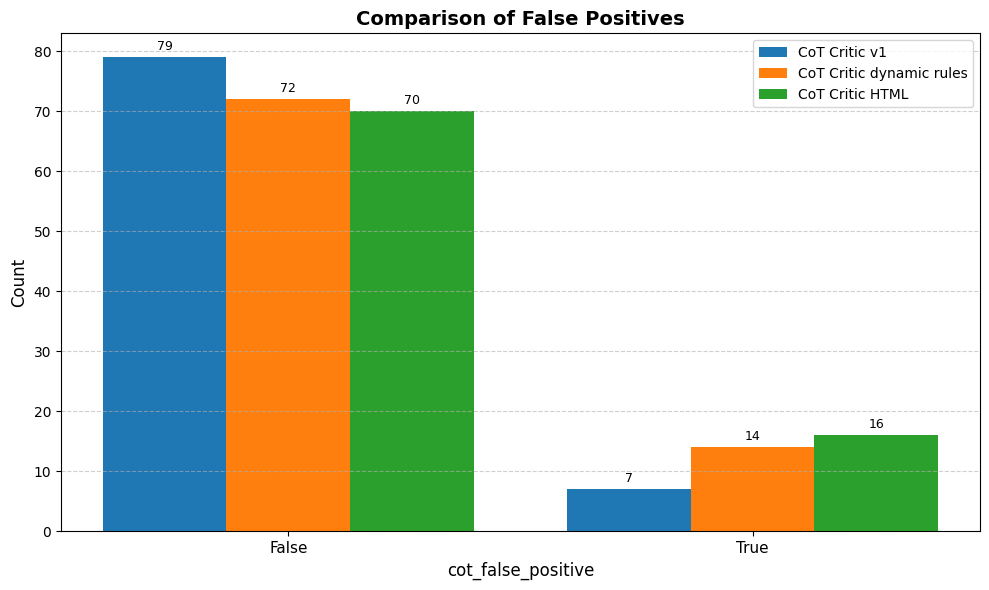

In [5]:
from utils import plot_grouped_bar_counts

plot_grouped_bar_counts(dfs=[df_demo, df_o4_md, df_o4],
                        column="cot_false_positive", 
                        labels=["CoT Critic v1", "CoT Critic dynamic rules", "CoT Critic HTML"],
                        title="Comparison of False Positives"
                        )

# AuditAgent Critic

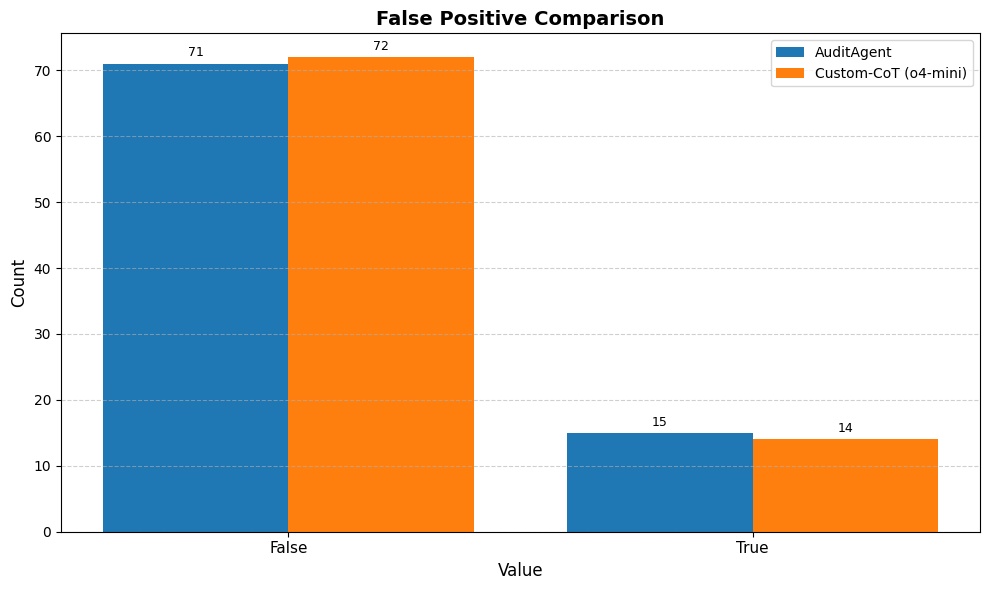

In [6]:
from utils import plot_grouped_bar_from_columns

plot_grouped_bar_from_columns(
    df=df_o4_md,
    columns=["v1_false_positive", "cot_false_positive"],
    labels=["AuditAgent", "Custom-CoT (o4-mini)"],
    title="False Positive Comparison"
)

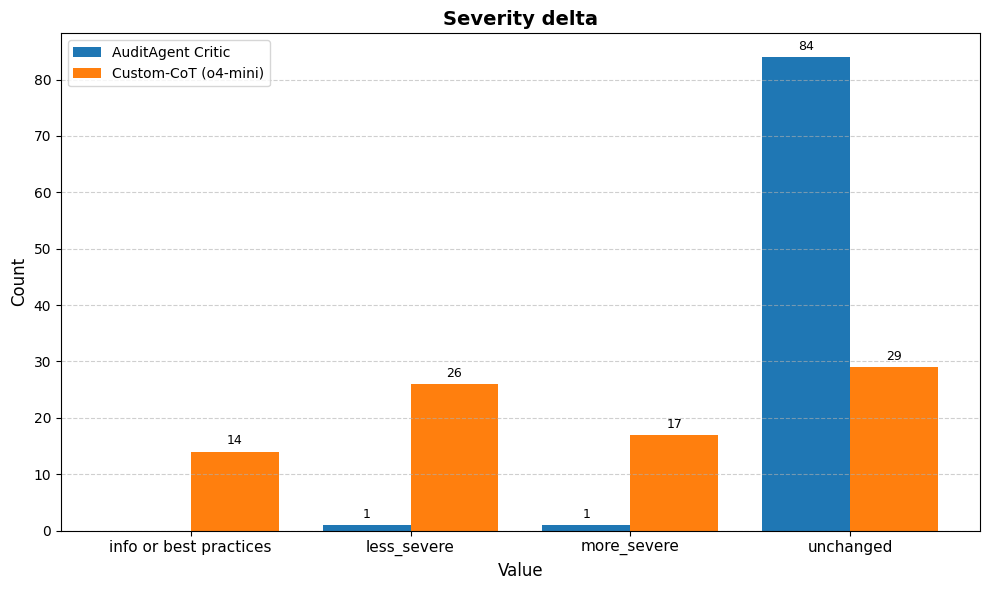

In [7]:
from utils import plot_grouped_bar_from_columns

plot_grouped_bar_from_columns(
    df=df_o4_md,
    columns=["v1_severity_delta", "cot_severity_delta"],
    labels=["AuditAgent Critic", "Custom-CoT (o4-mini)"],
    title="Severity delta"
)